# Time-Series MIA Example 
Base of example. Use and build upon this notebook during development.

In [1]:
import os, sys, yaml, numpy as np, matplotlib.pyplot as plt

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

from examples.mia.time_series_mia.utils.data_preparation import preprocess_ECG_dataset, get_ECG_dataloaders
from examples.mia.time_series_mia.utils.model_preparation import create_trained_model_and_metadata
from examples.mia.time_series_mia.utils.models.LSTM import LSTM
from examples.mia.time_series_mia.utils.models.TCN import TCN
from examples.mia.time_series_mia.utils.models.DLinear import DLinear
from examples.mia.time_series_mia.utils.models.TimesNet import TimesNet
from examples.mia.time_series_mia.utils.models.NBeats import NBeats
from examples.mia.time_series_mia.utils.models.TFT import TFT

In [ ]:
audit_config_path = "audit.yaml"
train_config_path = "train_config.yaml"

# Load the yaml files
with open(audit_config_path, 'r') as file:
    audit_config = yaml.safe_load(file)

with open(train_config_path, 'r') as file:
    train_config = yaml.safe_load(file)

In [ ]:
epochs = train_config["train"]["epochs"]
batch_size = train_config["train"]["batch_size"]
optimizer = train_config["train"]["optimizer"] # Fix so we use this

lookback = train_config["data"]["lookback"]
horizon = train_config["data"]["horizon"]
num_individuals = train_config["data"]["num_individuals"]
train_fraction = train_config["data"]["f_train"]
test_fraction = train_config["data"]["f_test"]
dataset = train_config["data"]["dataset"] # Fix so we use this
data_dir = train_config["data"]["data_dir"]

# Define constants
input_dim = 12 # input size will be the amount of variables in the Time-Series

In [4]:
# Get data loaders
path = os.path.join(os.getcwd(), data_dir)
dataset = preprocess_ECG_dataset(path, lookback, horizon, num_individuals)
train_loader, test_loader = get_ECG_dataloaders(dataset, train_fraction, test_fraction, batch_size=batch_size)

In [5]:
# Train the model
model_name = audit_config["target"]["model_class"]

if model_name == "LSTM":
    model = LSTM(input_dim, horizon)
elif model_name == "TCN":
    model = TCN(input_dim, horizon)
elif model_name == "DLinear":
    model = DLinear(input_dim, lookback, horizon)
elif model_name == "TimesNet":
    model = TimesNet(input_dim, lookback, horizon)
elif model_name == "NBeats":
    model = NBeats(input_dim, lookback, horizon)
elif model_name == "TFT":
    model = TFT(input_dim, lookback, horizon)
else:
    raise NotImplementedError()

train_loss, test_loss = create_trained_model_and_metadata(model, train_loader, test_loader, epochs)

Training Progress: 100%|██████████| 10/10 [01:48<00:00, 10.80s/it]


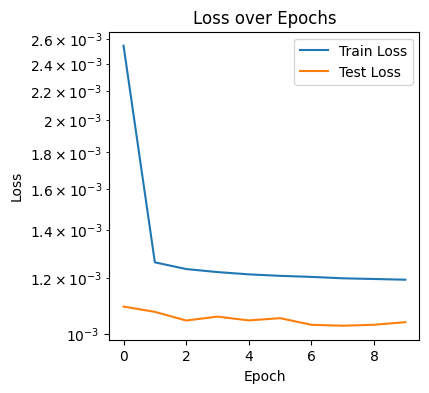

In [6]:
# Plot training and test loss
plt.figure(figsize=(4, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [7]:
from ECG_handler import ECGInputHandler
from leakpro import LeakPro

# Prepare leakpro object
leakpro = LeakPro(ECGInputHandler, audit_config_path)

# Run the audit 
leakpro.run_audit()

2025-02-20 15:15:27,319 INFO     Target model blueprint created from DLinear in ./utils/models/DLinear.py.
2025-02-20 15:15:27,344 INFO     Loaded target model metadata from ./target/model_metadata.pkl
c:\Users\totte\Documents\Kurser\DATX05 - Master's Thesis\LeakPro\leakpro\input_handler\handler_setup.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start se

{'audit': {'random_seed': 42, 'attack_list': {'ensemble': {'training_data_fraction': 0.5, 'attack_data_fraction': 0.5, 'num_instances': 50, 'subset_size': 50, 'num_pairs': 5, 'audit': True}}, 'output_dir': './leakpro_output', 'attack_type': 'mia', 'modality': 'time_series'}, 'target': {'module_path': './utils/models/DLinear.py', 'model_class': 'DLinear', 'target_folder': './target', 'data_path': './data/ECG.pkl'}, 'shadow_model': None, 'distillation_model': None}


2025-02-20 15:15:38,502 INFO     Loaded population dataset from ./data/ECG.pkl
2025-02-20 15:15:38,535 INFO     Loaded population dataset from ./data/ECG.pkl
2025-02-20 15:15:42,466 INFO     MIA attack factory loaded.
2025-02-20 15:15:42,467 INFO     Creating shadow model handler singleton
2025-02-20 15:15:42,472 INFO     Creating distillation model handler singleton
2025-02-20 15:15:42,477 INFO     Configuring Ensemble attack
2025-02-20 15:15:42,478 INFO     Added attack: ensemble
2025-02-20 15:15:42,479 INFO     Preparing attack: ensemble
2025-02-20 15:15:42,480 INFO     Preparing shadow models for Ensemble attack
2025-02-20 15:15:42,480 INFO     Preparing attack data for training the Ensemble attack
2025-02-20 15:15:42,510 INFO     self.attack_data_indices=array([388855, 481913, 242213, ...,  53305, 301428, 325221])
2025-02-20 15:15:42,511 INFO     Running attack: ensemble
2025-02-20 15:15:42,512 INFO     Running Ensemble shadow attack (audit mode)
2025-02-20 15:15:42,512 INFO     R

KeyboardInterrupt: 

### Testing signals

In [ ]:
print(f'Mean train MSE:', np.mean(train_loss))
print(f'Mean test MSE:', np.mean(test_loss))

Avg train MSE: 0.0010738943250353451
Avg test MSE: 0.0008281765227577994


In [ ]:
from torch.nn import MSELoss
from leakpro.signals.signal import SeasonalityLoss, TrendLoss
from leakpro.signals.signal_extractor import PytorchModel

pmodel = PytorchModel(model, MSELoss)

seasonality_signal = SeasonalityLoss()
train_sloss = seasonality_signal([pmodel], leakpro.handler, train_loader.dataset.indices)
test_sloss = seasonality_signal([pmodel], leakpro.handler, test_loader.dataset.indices)

trend_signal = TrendLoss()
train_tloss = trend_signal([pmodel], leakpro.handler, train_loader.dataset.indices)
test_tloss = trend_signal([pmodel], leakpro.handler, test_loader.dataset.indices)

print(f'Mean train seasonality loss:', np.mean(train_sloss))
print(f'Mean test seasonality loss:', np.mean(test_sloss))

print(f'Mean train trend loss:', np.mean(train_tloss))
print(f'Mean test trend loss:', np.mean(test_tloss))

Getting trend loss for model 1/ 1: 100%|██████████| 4576/4576 [00:11<00:00, 415.47it/s]

Mean train seasonality loss: 3.8450737130659878
Mean test seasonality loss: 3.8556961747737493
Mean train trend loss: 0.6672897970401903
Mean test trend loss: 0.6773139758794336
